<h1><center> Road Traffic Accidents Severity Classification </center></h1>

### Contents

- *Introduction*
- *Exploration des Data*
- *Pretraitement des données*
- *Modélisation*
- *Prediction and Evaluation*
- *Auto Ml*
- *Ml Flow*
- *SHAP et LIME*

In [3]:
pip install seaborn 

In [4]:
# Gestion du système de fichiers
import time, psutil, os, random

# Fonctions mathématiques
import math

# Manipulation de données
import numpy as np
import pandas as pd

# Visualisation et graphiques
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()  # Applique un thème par défaut aux graphiques


# Imputation des données manquantes
from sklearn.experimental import enable_iterative_imputer  # Active l'imputation itérative
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer  # Imputation de données manquantes par différentes méthodes

# Encodage des données catégorielles
from sklearn.preprocessing import LabelEncoder  # Convertir les variables catégorielles en variables numériques

# Séparation des données en ensembles d'entraînement et de test, et validation croisée en k-plis
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

# Sélection des caractéristiques
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif  # Méthodes pour sélectionner les caractéristiques les plus importantes

# Évaluation des modèles
from sklearn import metrics  # Outils pour évaluer les performances des modèles
from sklearn.metrics import f1_score  # Mesure de la performance F1 (précision et rappel)

## Intelligence artificielle explicable (explainable AI)
#!pip install --quiet shap==0.39.0  # Installation de la bibliothèque SHAP pour l'interprétabilité des modèles
#import shap  # Importation de SHAP pour rendre les modèles plus transparents et compréhensibles

# Suppression des avertissements
import warnings
warnings.filterwarnings('ignore')  # Ignore les avertissements pour une sortie plus propre



## 1. Introduction

#### 1.1. Data 

Source : [https://www.kaggle.com/saurabhshahane/road-traffic-accidents](https://www.kaggle.com/saurabhshahane/road-traffic-accidents)

Le jeu de données a été préparé à partir des enregistrements manuels des accidents de la route survenus entre 2017 et 2020, collectés auprès des départements de police des sous-villes d'Addis-Abeba. Les informations sensibles ont été exclues lors du processus d'encodage des données. Le jeu de données final contient des informations sur 12 316 accidents, chacun avec 32 caractéristiques.

In [6]:
data = pd.read_csv('./RTA Dataset.csv')  # Chargement du jeu de données  pour l'analyse

In [7]:
data.head()  # Afficher les 5 premières lignes du DataFrame pour avoir un aperçu rapide des données

,Time,Day_of_week,Age_band_of_driver,Sex_of_driver,Educational_level,Vehicle_driver_relation,Driving_experience,Type_of_vehicle,Owner_of_vehicle,Service_year_of_vehicle,...,Vehicle_movement,Casualty_class,Sex_of_casualty,Age_band_of_casualty,Casualty_severity,Work_of_casuality,Fitness_of_casuality,Pedestrian_movement,Cause_of_accident,Accident_severity
0,17:02:00,Monday,18-30,Male,Above high school,Employee,1-2yr,Automobile,Owner,Above 10yr,...,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Moving Backward,Slight Injury
1,17:02:00,Monday,31-50,Male,Junior high school,Employee,Above 10yr,Public (> 45 seats),Owner,5-10yrs,...,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury
2,17:02:00,Monday,18-30,Male,Junior high school,Employee,1-2yr,Lorry (41?100Q),Owner,NaN,...,Going straight,Driver or rider,Male,31-50,3,Driver,NaN,Not a Pedestrian,Changing lane to the left,Serious Injury
3,1:06:00,Sunday,18-30,Male,Junior high school,Employee,5-10yr,Public (> 45 seats),Governmental,NaN,...,Going straight,Pedestrian,Female,18-30,3,Driver,Normal,Not a Pedestrian,Changing lane to the right,Slight Injury
4,1:06:00,Sunday,18-30,Male,Junior high school,Employee,2-5yr,NaN,Owner,5-10yrs,...,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury


#### 1.2. Objectif du Projet

Le jeu de données contient des informations détaillées sur 12 316 accidents. Il comporte 31 variables prédictives et la variable cible *Accident_severity* qui peut prendre trois valeurs possibles : Léger, Grave et Mortel. L'objectif du projet est de construire des modèles de prédiction afin de classer la gravité d'un accident comme étant légère, grave ou mortelle, en fonction des informations pertinentes fournies par les 31 variables prédictives relatives à chaque accident particulier.

#### 1.3. Métrique d'Évaluation 

La précision (Precision) et le rappel (Recall) sont des métriques universellement acceptées pour évaluer la performance d'un modèle, respectivement limitées à la classe positive prédite et à la classe positive réelle. Soit :

- TP : Nombre de vrais positifs
- TN : Nombre de vrais négatifs
- FP : Nombre de faux positifs
- FN : Nombre de faux négatifs

En termes de ces quantités, la précision et le rappel sont définis comme suit :

- **Précision** = \(\frac{TP}{TP + FP}\)
- **Rappel** = \(\frac{TP}{TP + FN}\)

Le score F1 fournit une mesure équilibrée en considérant la moyenne harmonique de ces deux matrices.

- **Score F1** = \(\frac{2 \times \text{Précision} \times \text{Rappel}}{\text{Précision} + \text{Rappel}}\)

En raison de son égalité de poids accordée à la fois à la précision et au rappel, le score F1 est l'une des métriques les plus appropriées pour évaluer les modèles dans ce projet. Dans le jeu de données, nous avons une variable cible (*Accident_severity*) qui prend trois valeurs possibles, ce qui partitionne essentiellement le jeu de données en trois classes cibles. Cela peut être converti en une partition binaire en considérant une classe comme la classe positive et les deux autres combinées comme la classe négative. Cette partition positive-négative peut être réalisée du point de vue de chaque classe cible, produisant ainsi trois scores F1. Nous prenons le score F1 pondéré, qui est la moyenne de ces trois scores pondérée par le nombre d'instances réelles pour chaque classe, comme métrique d'évaluation pour évaluer les modèles.





## 2. Analyse Exploratoire des Données
#### 2.1. Exploration Basique des Données

In [10]:
# la taille de la data
print("Shape of the data: {}".format(data.shape))

Shape of the data: (12316, 32)


In [11]:
data.columns # Afficher la liste des noms de colonnes dans le DataFrame

Index(['Time', 'Day_of_week', 'Age_band_of_driver', 'Sex_of_driver',
       'Educational_level', 'Vehicle_driver_relation', 'Driving_experience',
       'Type_of_vehicle', 'Owner_of_vehicle', 'Service_year_of_vehicle',
       'Defect_of_vehicle', 'Area_accident_occured', 'Lanes_or_Medians',
       'Road_allignment', 'Types_of_Junction', 'Road_surface_type',
       'Road_surface_conditions', 'Light_conditions', 'Weather_conditions',
       'Type_of_collision', 'Number_of_vehicles_involved',
       'Number_of_casualties', 'Vehicle_movement', 'Casualty_class',
       'Sex_of_casualty', 'Age_band_of_casualty', 'Casualty_severity',
       'Work_of_casuality', 'Fitness_of_casuality', 'Pedestrian_movement',
       'Cause_of_accident', 'Accident_severity'],
      dtype='object')

In [12]:
data.info() # Afficher un résumé concis des informations sur le DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12316 entries, 0 to 12315
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Time                         12316 non-null  object
 1   Day_of_week                  12316 non-null  object
 2   Age_band_of_driver           12316 non-null  object
 3   Sex_of_driver                12316 non-null  object
 4   Educational_level            11575 non-null  object
 5   Vehicle_driver_relation      11737 non-null  object
 6   Driving_experience           11487 non-null  object
 7   Type_of_vehicle              11366 non-null  object
 8   Owner_of_vehicle             11834 non-null  object
 9   Service_year_of_vehicle      8388 non-null   object
 10  Defect_of_vehicle            7889 non-null   object
 11  Area_accident_occured        12077 non-null  object
 12  Lanes_or_Medians             11931 non-null  object
 13  Road_allignment              12

In [13]:
data.isnull().sum() # Compte le nombre de valeurs manquantes dans chaque colonne du DataFrame

Time                              0
Day_of_week                       0
Age_band_of_driver                0
Sex_of_driver                     0
Educational_level               741
Vehicle_driver_relation         579
Driving_experience              829
Type_of_vehicle                 950
Owner_of_vehicle                482
Service_year_of_vehicle        3928
Defect_of_vehicle              4427
Area_accident_occured           239
Lanes_or_Medians                385
Road_allignment                 142
Types_of_Junction               887
Road_surface_type               172
Road_surface_conditions           0
Light_conditions                  0
Weather_conditions                0
Type_of_collision               155
Number_of_vehicles_involved       0
Number_of_casualties              0
Vehicle_movement                308
Casualty_class                    0
Sex_of_casualty                   0
Age_band_of_casualty              0
Casualty_severity                 0
Work_of_casuality           

In [14]:
data # Affiche le contenu du DataFrame

,Time,Day_of_week,Age_band_of_driver,Sex_of_driver,Educational_level,Vehicle_driver_relation,Driving_experience,Type_of_vehicle,Owner_of_vehicle,Service_year_of_vehicle,...,Vehicle_movement,Casualty_class,Sex_of_casualty,Age_band_of_casualty,Casualty_severity,Work_of_casuality,Fitness_of_casuality,Pedestrian_movement,Cause_of_accident,Accident_severity
0,17:02:00,Monday,18-30,Male,Above high school,Employee,1-2yr,Automobile,Owner,Above 10yr,...,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Moving Backward,Slight Injury
1,17:02:00,Monday,31-50,Male,Junior high school,Employee,Above 10yr,Public (> 45 seats),Owner,5-10yrs,...,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury
2,17:02:00,Monday,18-30,Male,Junior high school,Employee,1-2yr,Lorry (41?100Q),Owner,NaN,...,Going straight,Driver or rider,Male,31-50,3,Driver,NaN,Not a Pedestrian,Changing lane to the left,Serious Injury
3,1:06:00,Sunday,18-30,Male,Junior high school,Employee,5-10yr,Public (> 45 seats),Governmental,NaN,...,Going straight,Pedestrian,Female,18-30,3,Driver,Normal,Not a Pedestrian,Changing lane to the right,Slight Injury
4,1:06:00,Sunday,18-30,Male,Junior high school,Employee,2-5yr,NaN,Owner,5-10yrs,...,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12311,16:15:00,Wednesday,31-50,Male,NaN,Employee,2-5yr,Lorry (11?40Q),Owner,NaN,...,Going straight,na,na,na,na,Driver,Normal,Not a Pedestrian,No distancing,Slight Injury
12312,18:00:00,Sunday,Unknown,Male,Elementary school,Employee,5-10yr,Automobile,Owner,NaN,...,Other,na,na,na,na,Driver,Normal,Not a Pedestrian,No distancing,Slight Injury
12313,13:55:00,Sunday,Over 51,Male,Junior high school,Employee,5-10yr,Bajaj,Owner,2-5yrs,...,Other,Driver or rider,Male,31-50,3,Driver,Normal,Not a Pedestrian,Changing lane to the right,Serious Injury
12314,13:55:00,Sunday,18-30,Female,Junior high school,Employee,Above 10yr,Lorry (41?100Q),Owner,2-5yrs,...,Other,na,na,na,na,Driver,Normal,Not a Pedestrian,Driving under the influence of drugs,Slight Injury


In [15]:
data.describe() # Fournit des statistiques descriptives pour les colonnes numériques du DataFrame

,Number_of_vehicles_involved,Number_of_casualties
count,12316.000000,12316.000000
mean,2.040679,1.548149
std,0.688790,1.007179
min,1.000000,1.000000
25%,2.000000,1.000000
50%,2.000000,1.000000
75%,2.000000,2.000000
max,7.000000,8.000000



#### 2.2. Visualisation des Données
La variable cible : Gravité de l'accident  
*Accident_severity* est une variable catégorielle avec trois valeurs possibles.



In [17]:
data['Accident_severity'].unique()  # Affiche les valeurs uniques présentes dans la colonne 'Accident_severity'

array(['Slight Injury', 'Serious Injury', 'Fatal injury'], dtype=object)

In [18]:
data['Accident_severity'].value_counts()  # Compte le nombre d'occurrences de chaque valeur unique dans la colonne 'Accident_severity'

Accident_severity
Slight Injury     10415
Serious Injury     1743
Fatal injury        158
Name: count, dtype: int64

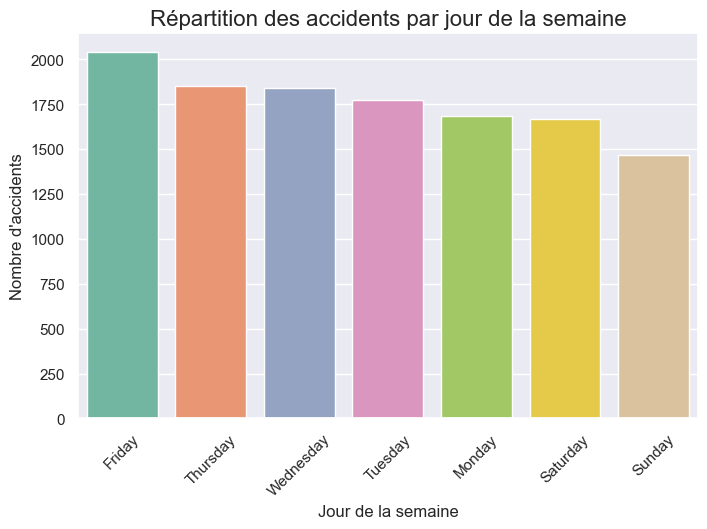

In [19]:
from matplotlib import pyplot as plt  # Importation de la bibliothèque matplotlib pour la création de graphiques
import seaborn as sns  # Importation de seaborn pour des visualisations statistiques avancées

plt.figure(figsize=(8, 5))  # Définir la taille de la figure du graphique

# Création d'un graphique à barres pour compter le nombre d'accidents par jour de la semaine.
sns.countplot(x='Day_of_week', data=data, order=data['Day_of_week'].value_counts().index, palette="Set2")  


plt.title("Répartition des accidents par jour de la semaine", fontsize=16)  # Titre du graphique
plt.xlabel("Jour de la semaine", fontsize=12)  # Label de l'axe des X (jour de la semaine) 
plt.ylabel("Nombre d'accidents", fontsize=12)  # Label de l'axe des Y (nombre d'accidents)

plt.xticks(rotation=45)  # Rotation des labels de l'axe des X de 45 degrés pour les rendre plus lisibles

plt.show()  # Afficher le graphique




### Analyse rapide :
- **Jour avec le plus d'accidents** : Vendredi enregistre le plus grand nombre d'accidents, ce qui peut s'expliquer par une circulation accrue en fin de semaine (sorties, déplacements professionnels ou privés).
- **Jour avec le moins d'accidents** : Dimanche a le plus faible nombre d'accidents, probablement dû à une diminution générale de la circulation ce jour-là.
- Les autres jours de la semaine (lundi à jeudi) montrent des valeurs proches, indiquant une répartition relativement stable des accidents en semaine.


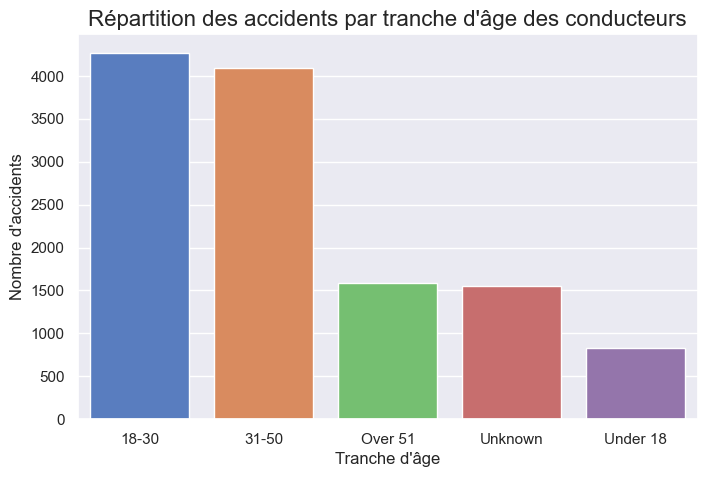

In [21]:
plt.figure(figsize=(8, 5))  # Définir la taille de la figure.


# Créer un graphique à barres (countplot) pour afficher la répartition des accidents en fonction des tranches d'âge des conducteurs.
sns.countplot(x='Age_band_of_driver', data=data, palette="muted", order=data['Age_band_of_driver'].value_counts().index)  

# Ajouter un titre au graphique.
plt.title("Répartition des accidents par tranche d'âge des conducteurs", fontsize=16)  

# Ajouter un label à l'axe des X (tranche d'âge des conducteurs).
plt.xlabel("Tranche d'âge", fontsize=12)  

# Ajouter un label à l'axe des Y (nombre d'accidents).
plt.ylabel("Nombre d'accidents", fontsize=12)  

# Afficher le graphique.
plt.show()  



### Analyse rapide :
Le graphique montre la répartition des accidents en fonction des tranches d'âge des conducteurs. On observe que les conducteurs âgés de **18 à 30 ans** et de **31 à 50 ans** représentent les catégories avec le plus grand nombre d'accidents, avec des chiffres proches et significativement plus élevés que les autres groupes. Les conducteurs de plus de 51 ans, ceux dont l'âge est inconnu, et les conducteurs de moins de 18 ans ont un nombre d'accidents sensiblement inférieur, ces derniers étant les moins impliqués.

Cette répartition peut indiquer que les conducteurs plus jeunes et ceux en âge actif (18-50 ans) sont plus exposés aux accidents, probablement en raison de leur plus grande présence sur la route ou de comportements plus risqués. En revanche, les conducteurs plus âgés ou mineurs semblent moins impliqués, possiblement en raison de leur fréquence de conduite réduite ou de comportements plus prudents.

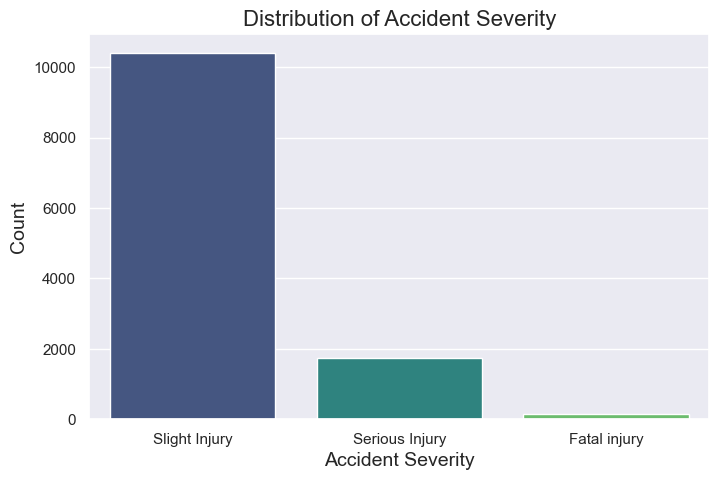

In [23]:
# Comptage des occurrences de chaque catégorie dans la colonne 'Accident_severity'
severity_counts = data['Accident_severity'].value_counts()

# Création d'une figure avec une taille de 8x5 
plt.figure(figsize=(8, 5))

# Création d'un graphique en barres avec les indices de 'severity_counts' sur l'axe des X
# et les valeurs de 'severity_counts' (nombre d'occurrences) sur l'axe des Y
sns.barplot(x=severity_counts.index, y=severity_counts.values, palette="viridis")

# Ajout d'un titre au graphique
plt.title('Distribution of Accident Severity', fontsize=16)

# Ajout de l'étiquette pour l'axe des X
plt.xlabel('Accident Severity', fontsize=14)

# Ajout de l'étiquette pour l'axe des Y
plt.ylabel('Count', fontsize=14)

# Affichage du graphique
plt.show()


### Analyse rapide :

Le graphique montre la distribution des accidents selon leur gravité. On observe que la grande majorité des accidents signalés entraînent des **blessures légères**, ce qui peut indiquer que les accidents graves ou mortels sont nettement moins fréquents. Les **blessures graves** représentent une proportion modérée, tandis que les **blessures mortelles** sont très rares, avec un nombre d'occurrences presque négligeable.


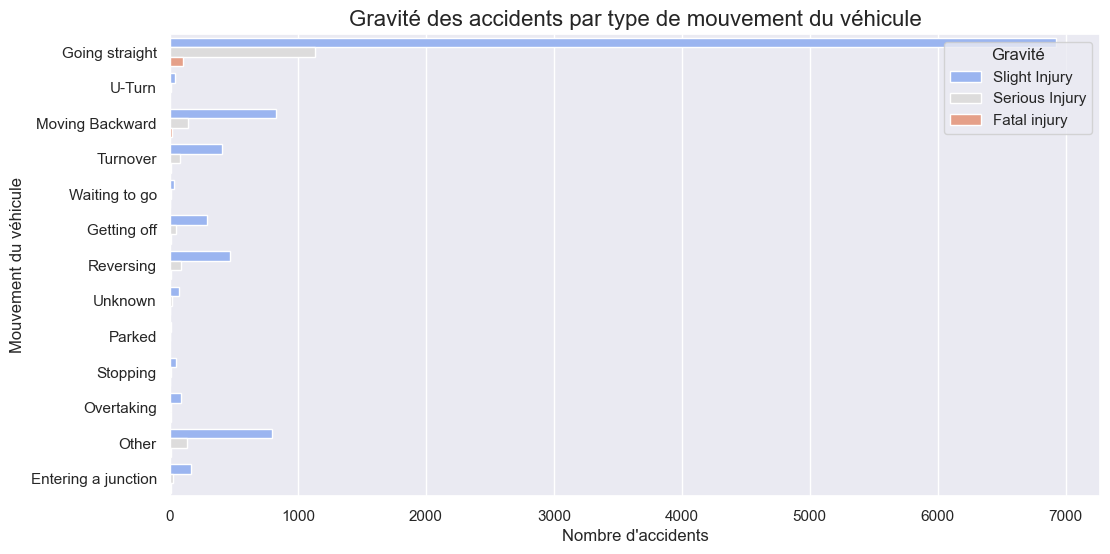

In [25]:
# Définir la taille de la figure.
plt.figure(figsize=(12, 6))  

# Créer un graphique à barres (countplot) horizontal pour afficher la répartition des accidents en fonction du type de mouvement du véhicule.
sns.countplot(y='Vehicle_movement', hue='Accident_severity', data=data, palette="coolwarm")  

# Ajouter un titre au graphique.
plt.title("Gravité des accidents par type de mouvement du véhicule", fontsize=16)  

# Ajouter un label à l'axe des X (nombre d'accidents).
plt.xlabel("Nombre d'accidents", fontsize=12)  

# Ajouter un label à l'axe des Y (type de mouvement du véhicule)
plt.ylabel("Mouvement du véhicule", fontsize=12)  

# Ajouter une légende pour la couleur des barres qui représente la gravité des accidents.
plt.legend(title="Gravité", loc="upper right")  

# Afficher le graphique.
plt.show()  


### Analyse rapide :

Le graphique montre la répartition des accidents en fonction du type de mouvement des véhicules, avec une distinction par gravité (blessures légères, graves ou fatales). On peut tirer les observations suivantes :

1. **Mouvement dominant : "Going Straight"**  
   La majorité des accidents surviennent lorsque les véhicules se déplacent en ligne droite, avec une prédominance de blessures légères. Cela peut s'expliquer par la fréquence élevée de ce type de déplacement et par des accidents typiques comme les collisions avant-arrière.

2. **Accidents notables pour d'autres mouvements :**  
   Des accidents sont également observés pour des mouvements comme **"Moving Backward"**, **"Overtaking"** et **"Entering a junction"**, mais dans des proportions bien moindres.

3. **Gravité :**  
   Les blessures légères dominent dans presque toutes les catégories de mouvement. Les blessures graves et les accidents mortels sont présents mais en nombre relativement faible, ce qui est rassurant en termes de sécurité routière.

4. **Contexte spécifique :**  
   Les types de mouvement comme **"Reversing"** ou **"U-Turn"** ont des fréquences plus faibles d'accidents, mais la gravité peut être variable selon le contexte et les conditions de circulation.



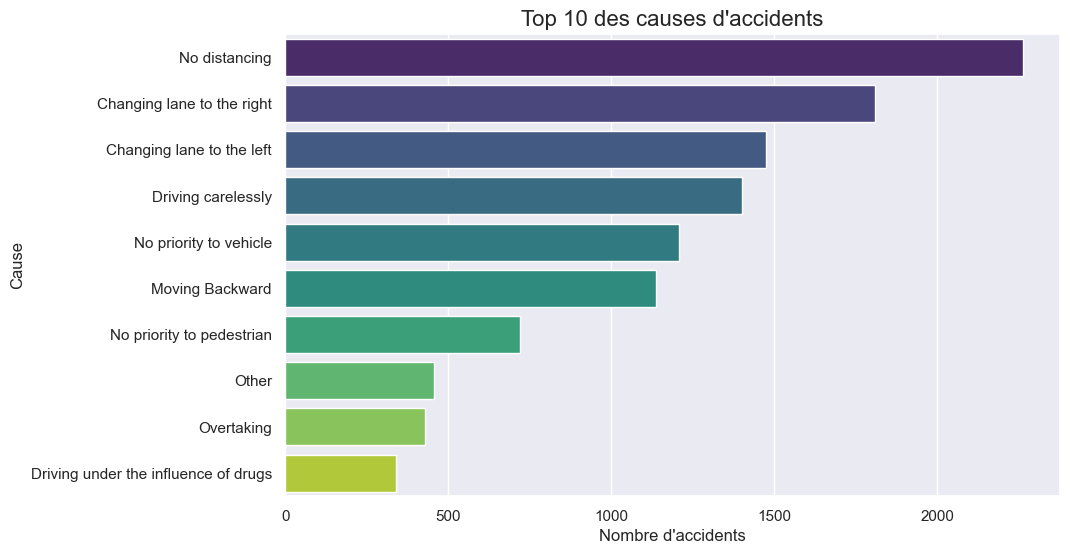

In [27]:
# Définir la taille de la figure à 10 pouces de large et 6 pouces de haut pour une meilleure lisibilité du graphique.
plt.figure(figsize=(10, 6))  

cause_counts = data['Cause_of_accident'].value_counts().head(10)  # Top 10 causes  

# Créer un graphique à barres horizontal (barplot) où l'axe X représente le nombre d'accidents pour chaque cause.
sns.barplot(x=cause_counts.values, y=cause_counts.index, palette="viridis")  

# Ajouter un titre au graphique, avec une taille de police de 16 pour le rendre bien visible.
plt.title("Top 10 des causes d'accidents", fontsize=16)  

# Ajouter un label à l'axe des X (nombre d'accidents).
plt.xlabel("Nombre d'accidents", fontsize=12)  

# Ajouter un label à l'axe des Y (cause de l'accident).
plt.ylabel("Cause", fontsize=12)  

# Afficher le graphique à l'écran.
plt.show()  


### Analyse rapide :

Le graphique montre les 10 principales causes d'accidents, classées par fréquence.

1. **Cause principale : "No distancing"**  
   Cette cause est nettement la plus fréquente avec plus de 2000 incidents, ce qui souligne l'importance du respect des distances de sécurité sur la route.  

2. **Changement de voie**  
   Les comportements liés au changement de voie ("à droite" et "à gauche") sont des causes majeures, indiquant un besoin d'éducation sur la signalisation et la vigilance lors de ces manœuvres.  

3. **Conduite imprudente**  
   La conduite imprudente figure également parmi les causes importantes, ce qui reflète un manque d’attention ou d’adaptation aux conditions de circulation.  

4. **Priorité non respectée**  
   Le non-respect des priorités, qu’il s’agisse de véhicules ou de piétons, est une cause importante, soulignant des comportements dangereux en intersections ou passages piétons.  

5. **Autres observations**  
   - Les accidents liés à des comportements moins fréquents, comme "Driving under the influence of drugs", restent significatifs mais nettement inférieurs aux principales causes.  
   - Les comportements inattentifs, comme "Moving backward", contribuent également au risque routier.  


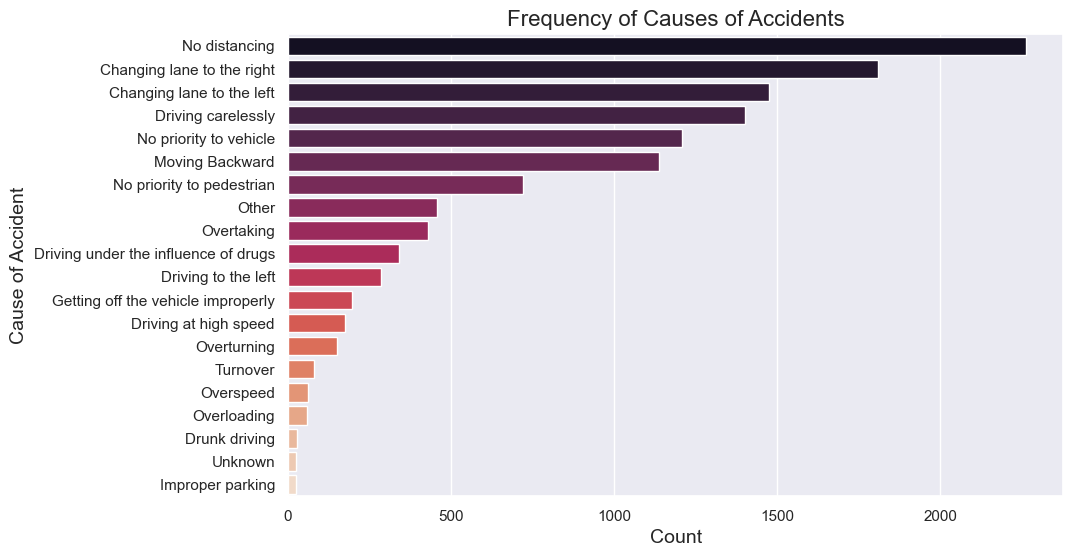

In [29]:
# Création d'une figure avec une taille de 10x6
plt.figure(figsize=(10, 6))

# Création d'un graphique en barres avec countplot pour afficher la fréquence des causes d'accidents
sns.countplot(data=data, y='Cause_of_accident', order=data['Cause_of_accident'].value_counts().index, palette="rocket")

# Ajout d'un titre explicatif au graphique
plt.title('Frequency of Causes of Accidents', fontsize=16)

# Ajout de l'étiquette pour l'axe des X (le nombre d'accidents par cause)
plt.xlabel('Count', fontsize=14)

# Ajout de l'étiquette pour l'axe des Y (les différentes causes d'accidents)
plt.ylabel('Cause of Accident', fontsize=14)

# Affichage du graphique
plt.show()


### Analyse rapide :

Le graphique montre la répartition des accidents en fonction du type de mouvement des véhicules, avec une distinction par gravité (blessures légères, graves ou fatales) :

1. **Mouvement dominant : "Going Straight"**  
   La majorité des accidents surviennent lorsque les véhicules se déplacent en ligne droite, avec une prédominance de blessures légères. Cela peut s'expliquer par la fréquence élevée de ce type de déplacement et par des accidents typiques comme les collisions avant-arrière.

2. **Accidents notables pour d'autres mouvements :**  
   Des accidents sont également observés pour des mouvements comme **"Moving Backward"**, **"Overtaking"** et **"Entering a junction"**, mais dans des proportions bien moindres.

3. **Gravité :**  
   Les blessures légères dominent dans presque toutes les catégories de mouvement. Les blessures graves et les accidents mortels sont présents mais en nombre relativement faible, ce qui est rassurant en termes de sécurité routière.

4. **Contexte spécifique :**  
   Les types de mouvement comme **"Reversing"** ou **"U-Turn"** ont des fréquences plus faibles d'accidents, mais la gravité peut être variable selon le contexte et les conditions de circulation.


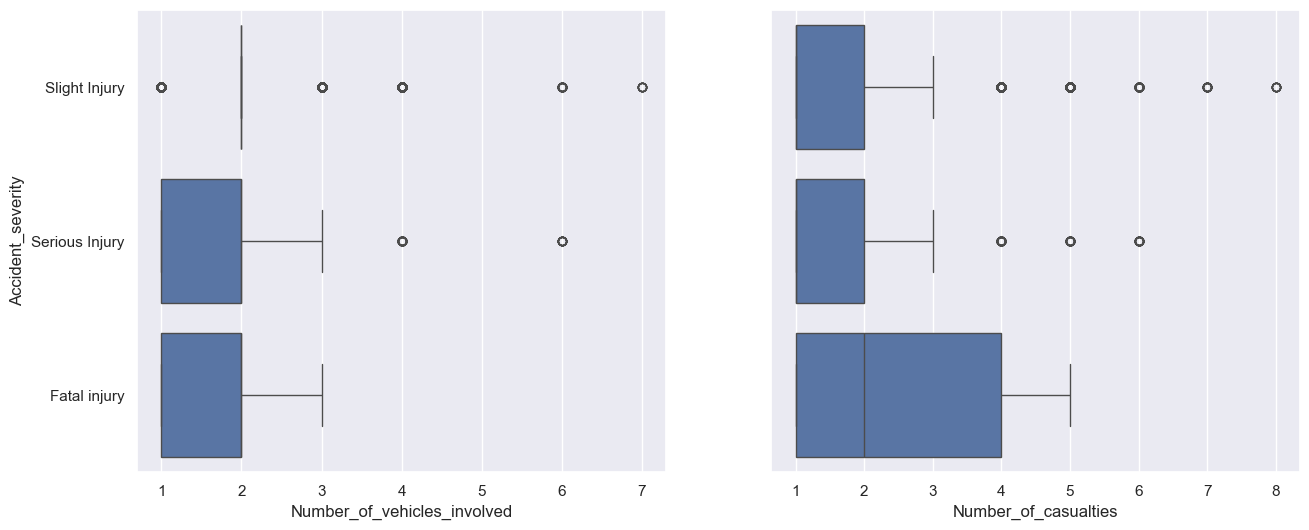

In [31]:
# Création d'une figure avec deux sous-graphes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 6))

# Création d'un graphique en boîte (boxplot) pour visualiser la relation entre le nombre de véhicules impliqués
# et la gravité des accidents.
sns.boxplot(data = data, x = 'Number_of_vehicles_involved', y = 'Accident_severity', ax = ax1)

# Création d'un graphique en boîte (boxplot) pour visualiser la relation entre le nombre de blessés
# et la gravité des accidents.

sns.boxplot(data = data, x = 'Number_of_casualties', y = 'Accident_severity', ax = ax2).set(yticklabels = [])

# Suppression de l'étiquette de l'axe Y du second graphique (ax2)
ax2.set_ylabel('')

# Affichage des deux graphiques côte à côte
plt.show()


Ce graphique comporte deux visualisations en boîte (boxplots) montrant la relation entre la gravité des accidents et deux facteurs clés : le nombre de véhicules impliqués et le nombre de victimes :  

 **1. Nombre de véhicules impliqués**  
   - Les accidents **mortels** (Fatal injury) impliquent souvent **1 à 3 véhicules**. Les valeurs aberrantes (outliers) indiquent que quelques accidents très graves ont impliqué jusqu'à 7 véhicules.  
   - Les accidents **graves** (Serious injury) montrent une tendance similaire, principalement entre **1 et 3 véhicules**, mais avec une distribution un peu plus étendue.  
   - Les accidents avec **blessures légères** (Slight injury) sont fortement concentrés sur des cas avec un seul véhicule impliqué.  

 **2. Nombre de victimes**  
   - Les accidents **mortels** affichent une large distribution du nombre de victimes, allant de **1 à 5**, avec des cas exceptionnels atteignant jusqu'à 8 victimes.  
   - Les accidents **graves** ont généralement entre **1 et 3 victimes**, avec des valeurs aberrantes légèrement plus fréquentes.  
   - Les accidents **légers** sont concentrés autour de **1 ou 2 victimes**, avec très peu de dispersion.  

 **Conclusions :**  
   - **Accidents graves et mortels** : Ils impliquent généralement plusieurs véhicules ou un nombre plus élevé de victimes, reflétant des incidents à fort impact.  
   - **Accidents légers** : Souvent limités à un seul véhicule et un faible nombre de victimes.  


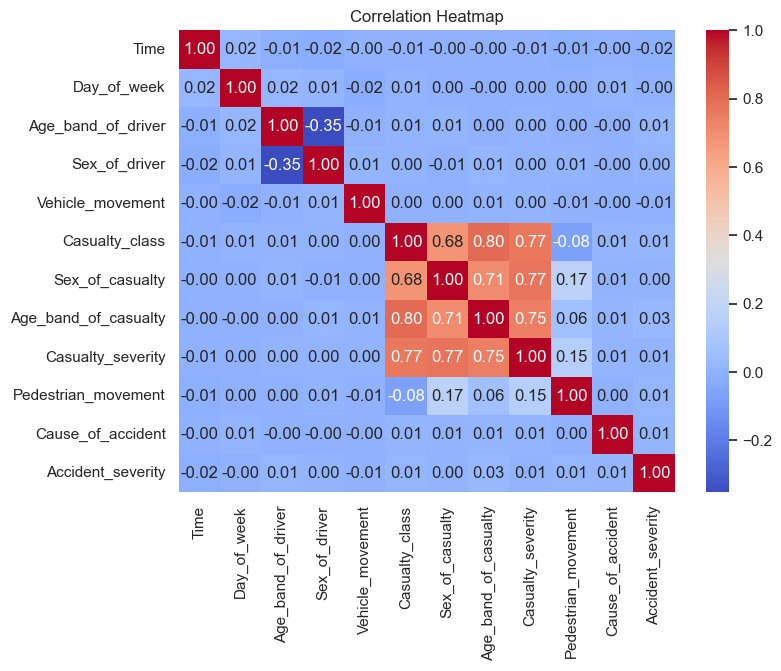

In [33]:
# Choisir les colonnes disponibles et spécifier la colonne cible 
available_columns = [
    "Time", "Day_of_week", "Age_band_of_driver", "Sex_of_driver",
    "Vehicle_movement", "Casualty_class", "Sex_of_casualty",
    "Age_band_of_casualty", "Casualty_severity", "Pedestrian_movement",
    "Cause_of_accident", "Accident_severity"
]

# Sélectionner les colonnes spécifiées dans la liste 'available_columns' à partir du DataFrame 'data'
df_selected = data[available_columns]

# Encoder les colonnes sélectionnées en valeurs numériques (catégorielles -> codes numériques)
# Cela permet de transformer les données catégorielles en données numériques pour pouvoir effectuer une analyse de corrélation
df_encoded = df_selected.apply(lambda col: col.astype('category').cat.codes)

# Calculer la matrice de corrélation entre les colonnes numériques encodées
# Cette matrice montre la force et la direction des relations linéaires entre les variables
correlation_matrix = df_encoded.corr()

# Visualiser la matrice de corrélation sous forme de carte thermique (heatmap)
#  définit les couleurs allant du bleu (corrélation négative) au rouge (corrélation positive)
plt.figure(figsize=(8, 6))  # Définir la taille du graphique
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")  
plt.title("Correlation Heatmap")  # Ajouter un titre 
plt.show()  # Afficher le graphique


## Analyse rapide:

Le heatmap de corrélation montre la relation entre plusieurs variables dans votre dataset:

1. *Variables fortement corrélées* :
   - Casualty_class a une forte corrélation positive avec Sex_of_casualty (0.68), Age_band_of_casualty (0.80), et Casualty_severity (0.77). Cela indique que ces variables sont probablement liées de manière significative dans votre dataset. Par exemple, la classe des victimes peut influencer leur gravité ou être liée à leur âge/sexe.
   - Casualty_severity est également fortement corrélé à Age_band_of_casualty (0.75), ce qui pourrait indiquer une tendance entre l'âge et la gravité des blessures.

2. *Corrélations faibles ou nulles* :
   - Plusieurs variables, comme Time, Day_of_week, et Cause_of_accident, montrent peu ou pas de corrélation significative avec les autres variables (valeurs proches de 0). Cela signifie qu'elles n'ont probablement pas d'influence linéaire forte sur d'autres attributs.
   - Par exemple, Time est pratiquement indépendant des autres variables.

3. *Corrélations négatives* :
   - La seule corrélation négative significative visible est entre Pedestrian_movement et Casualty_class (-0.08), bien que la valeur soit assez faible.

4. *Insight général* :
   - Les variables liées à la victime (Casualty_class, Sex_of_casualty, Age_band_of_casualty, Casualty_severity) montrent des relations fortes entre elles, ce qui est logique dans le contexte d'accidents, où des attributs personnels sont souvent interconnectés.
   - Des corrélations faibles ou nulles entre des facteurs tels que Cause_of_accident et d'autres variables suggèrent qu'elles peuvent être influencées par des facteurs externes ou non capturés dans ce dataset.



## 3. Pretraitement des données
#### 3.1. Standardisation  
- Les valeurs catégoriques sont standarisé pour garantir leur cohérence :  
  - `Unknown` est remplacé par `unknown`.  
  - `Other` est remplacé par `other`.  
  - `Unknown or other` est regroupé sous `other`.  
- La colonne `Age_band_of_casualty` subit une transformation spécifique :  
  - La valeur `5` est renommée en `Under 18` pour plus de clarté. 

In [36]:
# Standardisation des valeurs
data = data.replace('Unknown', 'unknown')
data = data.replace('Other', 'other')
data = data.replace('Unknown or other', 'other')


In [37]:
# Convertir unknown/other/na à nan
data = data.replace('unknown', np.nan)
data = data.replace('other', np.nan)
data = data.replace('na', np.nan)

#### 3.2. Traitement des valeurs manquates

In [39]:
# afficher le pourcentage des valeurs nulls 
missing_percentage = (data.isnull().sum() / len(data)) * 100
print(missing_percentage)

Time                            0.000000
Day_of_week                     0.000000
Age_band_of_driver             12.569016
Sex_of_driver                   1.445274
Educational_level               6.828516
Vehicle_driver_relation         5.813576
Driving_experience              6.999026
Type_of_vehicle                17.521923
Owner_of_vehicle                4.092238
Service_year_of_vehicle        55.302046
Defect_of_vehicle              35.945112
Area_accident_occured          33.127639
Lanes_or_Medians               17.067230
Road_allignment                 1.152972
Types_of_Junction              12.366028
Road_surface_type               2.752517
Road_surface_conditions         0.000000
Light_conditions                0.000000
Weather_conditions              4.774277
Type_of_collision               1.583306
Number_of_vehicles_involved     0.000000
Number_of_casualties            0.000000
Vehicle_movement               10.823319
Casualty_class                 36.075024
Sex_of_casualty 

On a trouvé des colonnes qui ont plus de 35% des valeurs nulls , c'est pour ça on a décidé de les supprimer et aussi les colonnes qui sont trop correlée d'après la matrice de correlation

In [41]:
# Suppression des colonnes
data.drop(['Service_year_of_vehicle', 'Work_of_casuality','Sex_of_casualty','Defect_of_vehicle',"Casualty_class","Casualty_severity"], axis=1, inplace=True)


In [42]:
data.columns

Index(['Time', 'Day_of_week', 'Age_band_of_driver', 'Sex_of_driver',
       'Educational_level', 'Vehicle_driver_relation', 'Driving_experience',
       'Type_of_vehicle', 'Owner_of_vehicle', 'Area_accident_occured',
       'Lanes_or_Medians', 'Road_allignment', 'Types_of_Junction',
       'Road_surface_type', 'Road_surface_conditions', 'Light_conditions',
       'Weather_conditions', 'Type_of_collision',
       'Number_of_vehicles_involved', 'Number_of_casualties',
       'Vehicle_movement', 'Age_band_of_casualty', 'Fitness_of_casuality',
       'Pedestrian_movement', 'Cause_of_accident', 'Accident_severity'],
      dtype='object')

-  Dans cette partie , on va remplir les valeurs manquantes en utilisant la valeur la plus fréquente (mode) de chaque colonne 

In [44]:
# Liste des colonnes à remplir avec leur mode
columns_to_fill_mode = [
    'Driving_experience', 'Age_band_of_driver', 'Type_of_vehicle', 
    'Area_accident_occured', 'Road_allignment', 'Type_of_collision', 
    'Vehicle_movement', 'Lanes_or_Medians', 'Types_of_Junction', 
    'Educational_level', 'Vehicle_driver_relation', 'Owner_of_vehicle', 
    'Road_surface_type', 'Sex_of_driver', 'Cause_of_accident', 
    'Pedestrian_movement', 'Age_band_of_casualty', 'Weather_conditions','Fitness_of_casuality'
]

# Remplir les valeurs manquantes avec le mode de chaque colonne
for column in columns_to_fill_mode:
    data[column].fillna(data[column].mode()[0], inplace=True)


In [45]:
data.isnull().sum()

Time                           0
Day_of_week                    0
Age_band_of_driver             0
Sex_of_driver                  0
Educational_level              0
Vehicle_driver_relation        0
Driving_experience             0
Type_of_vehicle                0
Owner_of_vehicle               0
Area_accident_occured          0
Lanes_or_Medians               0
Road_allignment                0
Types_of_Junction              0
Road_surface_type              0
Road_surface_conditions        0
Light_conditions               0
Weather_conditions             0
Type_of_collision              0
Number_of_vehicles_involved    0
Number_of_casualties           0
Vehicle_movement               0
Age_band_of_casualty           0
Fitness_of_casuality           0
Pedestrian_movement            0
Cause_of_accident              0
Accident_severity              0
dtype: int64

#### 3.3. Traitement de la colonne Time
- 00:00:00 → 0 (minuit)
- 06:00:00 → 21600 (6 heures du matin)
- 12:00:00 → 43200 (12 heures, midi)
- 18:00:00 → 64800 (18 heures, 6 heures du soir)
- 24:00:00 → 86400 (minuit du jour suivant)

In [47]:
# Convertir time de hh:mm:ss format à seconds
def convert_to_seconds(x):
    h = int(x.split(':')[0])
    m = int(x.split(':')[1])
    s = int(x.split(':')[2])
    return (h*60*60)+(m*60)+s

data['Time'] = data['Time'].apply(convert_to_seconds)

In [48]:
data['Time']

0        61320
1        61320
2        61320
3         3960
4         3960
         ...  
12311    58500
12312    64800
12313    50100
12314    50100
12315    50100
Name: Time, Length: 12316, dtype: int64

#### 3.4. Encodage des données catégoriels
##### **3.4.1. Classification des variables**
Dans notre données , il y a 3 types des données  :
- numériques : de type int comme `Number_of_vehicles_involved`
- ordinales : qui ont un ordre ou un classement à respecter comme `Educational_level`
- non ordinales : qui n'ont pas un ordre à suivre comme `Type_of_vehicle`

In [50]:
numerical_cols = ['Time', 'Number_of_vehicles_involved', 'Number_of_casualties']
ordinal_cols = ['Age_band_of_driver', 'Educational_level','Driving_experience', 'Light_conditions']
non_ordinal_cols = [x for x in data.columns if x not in numerical_cols + ordinal_cols]

##### **3.4.2. Encodage des valeurs ordinales**
Pour chaque colonne spécifiée dans la liste des colonnes ordinales, nous utiliserons un dictionnaire de mappage pour remplacer les valeurs catégorielles par des valeurs numériques.


In [52]:
# creation de mappings
Age_band_of_driver_dict = {'Under 18' : 1, '18-30' : 2, '31-50' : 3, 'Over 51' : 4, 'unknown' : 10, 1 : 1, 2 : 2, 3 : 3, 4 : 4, 10 : 10}
Educational_level_dict = {'Illiterate' : 1, 'Writing & reading' : 2, 'Elementary school' : 3, 'Junior high school' : 4, 'High school' : 5, 'Above high school' : 6, 'unknown' : 10, 1 : 1, 2 : 2, 3 : 3, 4 : 4, 5 : 5, 6 : 6, 10 : 10}
Driving_experience_dict = {'Below 1yr' : 1, '1-2yr' : 2, '2-5yr' : 3, '5-10yr' : 4, 'Above 10yr' : 5, 'No Licence' : 0, 'unknown' : 10, 1 : 1, 2 : 2, 3 : 3, 4 : 4, 5 : 5, 8 : 8, 10 : 10}
Light_conditions_dict = {'Darkness - no lighting' : 1, 'Darkness - lights lit' : 2, 'Daylight' : 3, 1 : 1, 2 : 2, 3 : 3}
Accident_severity_dict = {'Slight Injury' : 1, 'Serious Injury' : 2, 'Fatal injury' : 3, 1 : 1, 2 : 2, 3 : 3}

In [53]:
encoder_dict = {'Age_band_of_driver' : Age_band_of_driver_dict,
                       'Educational_level' : Educational_level_dict,
                       'Driving_experience' : Driving_experience_dict,
                       'Light_conditions' : Light_conditions_dict,
                       'Accident_severity' : Accident_severity_dict
                      }

In [54]:
# remplacer les valeurs
for feature in ordinal_cols:
    if feature in encoder_dict:
        data[feature] = data[feature].map(encoder_dict[feature])

In [55]:
data.head()

,Time,Day_of_week,Age_band_of_driver,Sex_of_driver,Educational_level,Vehicle_driver_relation,Driving_experience,Type_of_vehicle,Owner_of_vehicle,Area_accident_occured,...,Weather_conditions,Type_of_collision,Number_of_vehicles_involved,Number_of_casualties,Vehicle_movement,Age_band_of_casualty,Fitness_of_casuality,Pedestrian_movement,Cause_of_accident,Accident_severity
0,61320,Monday,2,Male,6,Employee,2,Automobile,Owner,Residential areas,...,Normal,Collision with roadside-parked vehicles,2,2,Going straight,18-30,Normal,Not a Pedestrian,Moving Backward,Slight Injury
1,61320,Monday,3,Male,4,Employee,5,Public (> 45 seats),Owner,Office areas,...,Normal,Vehicle with vehicle collision,2,2,Going straight,18-30,Normal,Not a Pedestrian,Overtaking,Slight Injury
2,61320,Monday,2,Male,4,Employee,2,Lorry (41?100Q),Owner,Recreational areas,...,Normal,Collision with roadside objects,2,2,Going straight,31-50,Normal,Not a Pedestrian,Changing lane to the left,Serious Injury
3,3960,Sunday,2,Male,4,Employee,4,Public (> 45 seats),Governmental,Office areas,...,Normal,Vehicle with vehicle collision,2,2,Going straight,18-30,Normal,Not a Pedestrian,Changing lane to the right,Slight Injury
4,3960,Sunday,2,Male,4,Employee,3,Automobile,Owner,Industrial areas,...,Normal,Vehicle with vehicle collision,2,2,Going straight,18-30,Normal,Not a Pedestrian,Overtaking,Slight Injury


##### **3.4.2. Encodage des valeurs non ordinales**
On a utilisé Label Encoding qui attribue un numéro unique à chaque catégorie, ce qui réduit la dimensionnalité du dataset.

In [58]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
# Appliquer le Label Encoding pour chaque colonne de la liste
for col in non_ordinal_cols:
    data[col] = label_encoder.fit_transform(data[col])

In [59]:
data.head()

,Time,Day_of_week,Age_band_of_driver,Sex_of_driver,Educational_level,Vehicle_driver_relation,Driving_experience,Type_of_vehicle,Owner_of_vehicle,Area_accident_occured,...,Weather_conditions,Type_of_collision,Number_of_vehicles_involved,Number_of_casualties,Vehicle_movement,Age_band_of_casualty,Fitness_of_casuality,Pedestrian_movement,Cause_of_accident,Accident_severity
0,61320,1,2,1,6,0,2,0,2,8,...,2,3,2,2,2,0,2,5,9,2
1,61320,1,3,1,4,0,5,10,2,6,...,2,6,2,2,2,0,2,5,15,2
2,61320,1,2,1,4,0,2,5,2,1,...,2,2,2,2,2,1,2,5,0,1
3,3960,3,2,1,4,0,4,10,0,6,...,2,6,2,2,2,0,2,5,1,2
4,3960,3,2,1,4,0,3,0,2,4,...,2,6,2,2,2,0,2,5,15,2


In [60]:
data['Light_conditions'].fillna(data['Light_conditions'].mode()[0], inplace=True)

## 4. AutoML avec PyCaret


### 4.1. Application de PyCaret

Avec la bibliothèque PyCaret, la fonction `setup()` est utilisée pour configurer l'environnement de travail en spécifiant le jeu de données (`data`), la variable cible (`'Accident_severity'`), et un identifiant de session (`session_id = 123`) pour assurer la reproductibilité. Après cette étape de configuration, la fonction `compare_models()` est appelée pour comparer différents modèles de classification. LightGBM est le plus performant.


In [64]:
from pycaret.classification import * 

ModuleNotFoundError: No module named 'pycaret'

In [82]:
pip install pycaret

^C
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install setuptools

In [ ]:
from pycaret.classification import *
# configurer l'environnement de travail
s = setup(data, target = 'Accident_severity', session_id = 123)

In [ ]:
# comparer les modèles
best = compare_models()

### 4.2. Tester les performances du modèle

La matrice de confusion montre les performances du modèle *LGBMClassifier*. Le modèle prédit efficacement la classe majoritaire (classe 2) avec 3108 prédictions correctes, mais montre des difficultés à distinguer les classes 0 et 1. On observe des erreurs notables, notamment des classements de la classe 0 en classe 2 (41 fois).

In [ ]:
# afficher la matrice de confusion
plot_model(best, plot = 'confusion_matrix')

Les courbes ROC montrent les performances de classification pour chaque classe. Les AUC (Area Under Curve) indiquent une bonne capacité de distinction pour la classe 0 (AUC = 0.85), mais des performances plus faibles pour les classes 1 et 2 (AUC = 0.68 pour les deux). L'AUC micro-moyennée (0.94) suggère une bonne performance globale du modèle, tandis que l'AUC macro-moyennée (0.74) reflète un déséquilibre dans la performance entre les classes.

In [ ]:
# afficher la courbe ROC-AUC
plot_model(best, plot = 'auc')

Le graphique d'importance des variables montre que la variable **Time** est de loin la plus influente pour le modèle, suivie par **Cause_of_accident** et **Day_of_week**. D'autres variables comme **Type_of_vehicle**, **Area_accident_occurred** et **Types_of_Junction** contribuent également de manière notable. Les variables liées au conducteur et aux victimes (par exemple, **Driving_experience**, **Age_band_of_driver**, et **Age_band_of_casualty**) jouent un rôle moins important dans les prédictions. Ces résultats mettent en lumière les facteurs clés influençant les prédictions du modèle.


In [ ]:
# afficher les colonnes importantes
plot_model(best, plot = 'feature')

# 5. Modélisation


## 5.1. Données d'entrainement et de test

Pour entraîner notre modèle, nous avons séparé les données en ensembles d'entraînement et de test. La variable cible '**Accident_severity**' représente la gravité des accidents, tandis que les autres colonnes constituent les caractéristiques indépendantes. Nous avons utilisé une division stratifiée pour maintenir une répartition équilibrée des classes dans les ensembles.

In [104]:
y = data['Accident_severity'] # variable cible
X = data.drop('Accident_severity', axis = 1) # variables indépendantes

In [106]:
# Ensemble d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.3, shuffle = True)

## 5.2. Random Forest


### Entrainement du modèle

 Nous utilisons `GridSearchCV` pour optimiser les hyperparamètres du modèle `RandomForestClassifier`. Les paramètres testés incluent :  
   - `n_estimators` : Nombre d'arbres dans la forêt.  
   - `max_depth` : Profondeur maximale des arbres pour contrôler leur complexité.    
   - `min_samples_split` : option pour contrôler le surapprentissage.  
   La validation croisée avec 3 plis permet d'obtenir une évaluation robuste des performances.

In [111]:
from sklearn.ensemble import RandomForestClassifier

# Initialisation du classificateur de forêt aléatoire 

rf = RandomForestClassifier(random_state=42)

In [113]:
param_grid_random_forest = {
    'n_estimators': [100, 200,500],  
    'max_depth': [10, 20],  
    'min_samples_split': [2, 5, 10],    
}


In [115]:
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_random_forest,
    cv=3,
    scoring='accuracy',
    verbose=3,
    error_score='raise'
)
grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV 1/3] END max_depth=10, min_samples_split=2, n_estimators=100;, score=0.850 total time=   0.7s
[CV 2/3] END max_depth=10, min_samples_split=2, n_estimators=100;, score=0.847 total time=   0.8s
[CV 3/3] END max_depth=10, min_samples_split=2, n_estimators=100;, score=0.848 total time=   0.7s
[CV 1/3] END max_depth=10, min_samples_split=2, n_estimators=200;, score=0.849 total time=   1.6s
[CV 2/3] END max_depth=10, min_samples_split=2, n_estimators=200;, score=0.847 total time=   1.5s
[CV 3/3] END max_depth=10, min_samples_split=2, n_estimators=200;, score=0.849 total time=   1.5s
[CV 1/3] END max_depth=10, min_samples_split=2, n_estimators=500;, score=0.849 total time=   4.1s
[CV 2/3] END max_depth=10, min_samples_split=2, n_estimators=500;, score=0.846 total time=   3.9s
[CV 3/3] END max_depth=10, min_samples_split=2, n_estimators=500;, score=0.848 total time=   3.9s
[CV 1/3] END max_depth=10, min_samples_split=5, n_estimat

GridSearchCV(cv=3, error_score='raise',
             estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [10, 20], 'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 500]},
             scoring='accuracy', verbose=3)

### Tester les performences du modèle

Le rapport de classification montre une précision globale de **85 %** avec un fort déséquilibre entre les classes. La classe **2** est bien prédite (F1-score de **0,92**), tandis que les classes **0** et **1** sont mal prises en compte, avec des F1-scores de **0,00** et **0,04** respectivement. 

In [117]:
best_model_rf = grid_search.best_estimator_

In [119]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Prédiction des étiquettes de test 
y_pred_rf = best_model_rf.predict(X_test)

# Affichage du rapport de classification
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       1.00      0.04      0.08        47
           1       0.69      0.05      0.09       523
           2       0.85      1.00      0.92      3125

    accuracy                           0.85      3695
   macro avg       0.85      0.36      0.36      3695
weighted avg       0.83      0.85      0.79      3695



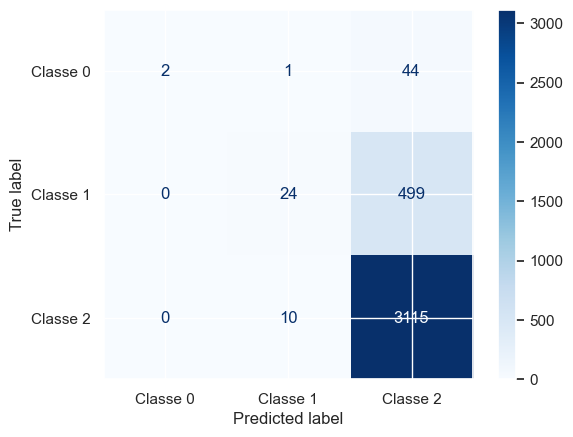

In [121]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calcul de la matrice de confusion
cm = confusion_matrix(y_test, y_pred_rf)

# Affichage de la matrice de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Classe 0', 'Classe 1','Classe 2'])  # Modifier les labels selon vos classes
disp.plot(cmap='Blues')


Le graphique représente les courbes ROC pour les trois classes. La classe **0** présente une bonne performance avec une AUC de **0.81**, indiquant une capacité élevée à distinguer les exemples positifs des négatifs. En revanche, les classes **1** et **2** ont une AUC de **0.68**, ce qui reflète une performance plus modérée. 

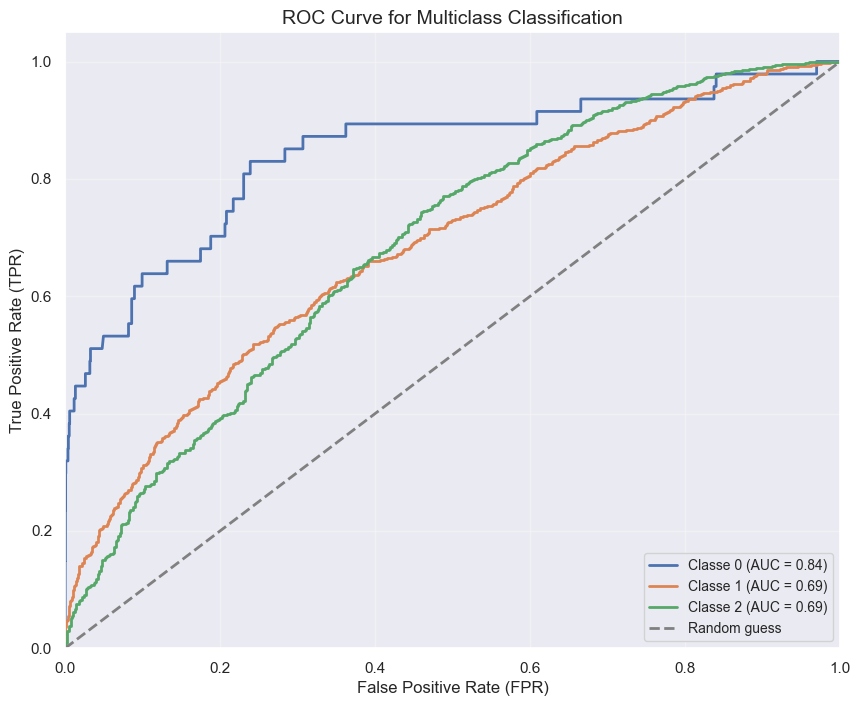

In [124]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt


# Binariser les labels
classes = np.unique(y_test) 
y_test_binarized = label_binarize(y_test, classes=classes)
y_proba_rf = grid_search.predict_proba(X_test)  # Probabilités de chaque classe

# Tracer les courbes ROC pour chaque classe
plt.figure(figsize=(10, 8))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_proba_rf[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Classe {class_label} (AUC = {roc_auc:.2f})')

# Ajouter des éléments au graphique
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC Curve for Multiclass Classification', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.show()


## 5.2. XGBoost

### Entrainement du modèle


Nous utilisons `GridSearchCV` pour optimiser les hyperparamètres du modèle `XGBClassifier`. Les paramètres testés incluent :  
   - `n_estimators` : Nombre d'arbres dans le modèle.  
   - `max_depth` : Profondeur maximale des arbres pour ajuster leur complexité.  
   - `learning_rate` : Taux d'apprentissage pour contrôler l'impact de chaque arbre ajouté.  
   - `subsample` : Taux d'échantillonnage des données utilisé pour chaque arbre, permettant de réduire le surapprentissage.  

In [130]:
from xgboost import XGBClassifier
# Initialisation du classificateur XGBoost
xgb = XGBClassifier(random_state=42)

In [128]:
pip install xgboost

   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 1.3/124.9 MB 5.6 MB/s eta 0:00:23
    --------------------------------------- 2.4/124.9 MB 5.4 MB/s eta 0:00:23
   - -------------------------------------- 3.4/124.9 MB 5.4 MB/s eta 0:00:23
   - -------------------------------------- 4.7/124.9 MB 5.5 MB/s eta 0:00:22
   - -------------------------------------- 6.0/124.9 MB 5.5 MB/s eta 0:00:22
   -- ------------------------------------- 6.6/124.9 MB 5.3 MB/s eta 0:00:23
   -- ------------------------------------- 7.9/124.9 MB 5.2 MB/s eta 0:00:23
   -- ------------------------------------- 8.9/124.9 MB 5.2 MB/s eta 0:00:23
   --- ------------------------------------ 10.2/124.9 MB 5.2 MB/s eta 0:00:22
   --- ------------------------------------ 11.3/124.9 MB 5.3 MB/s eta 0:00:22
   --- ------------------------------------ 12.3/124.9 MB 5.3 MB/s eta 0:00:

In [132]:
# Hyperparamètres à tester
param_grid = {
    'n_estimators': [100, 200, 500],  # Plus d'arbres pour de meilleures performances
    'max_depth': [10, 20],  # Arbres plus profonds pour plus de complexité
    'learning_rate': [0.01, 0.1],  # Taux d'apprentissage
    'subsample': [0.8, 1.0],  # Pour l'échantillonnage
}


In [134]:

# Recherche de grille avec validation croisée
grid_search_xgboost = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    verbose=3,
    error_score='raise'
)
# Entraînement du modèle
grid_search_xgboost.fit(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3] END learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.8;, score=0.854 total time=   0.5s
[CV 2/3] END learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.8;, score=0.849 total time=   0.5s
[CV 3/3] END learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.8;, score=0.852 total time=   0.5s
[CV 1/3] END learning_rate=0.01, max_depth=10, n_estimators=100, subsample=1.0;, score=0.851 total time=   0.4s
[CV 2/3] END learning_rate=0.01, max_depth=10, n_estimators=100, subsample=1.0;, score=0.849 total time=   0.4s
[CV 3/3] END learning_rate=0.01, max_depth=10, n_estimators=100, subsample=1.0;, score=0.851 total time=   0.4s
[CV 1/3] END learning_rate=0.01, max_depth=10, n_estimators=200, subsample=0.8;, score=0.855 total time=   0.9s
[CV 2/3] END learning_rate=0.01, max_depth=10, n_estimators=200, subsample=0.8;, score=0.849 total time=   1.0s
[CV 3/3] END learning_rate=0.01, max_depth=

GridSearchCV(cv=3, error_score='raise',
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [10, 20],
                         'n_estimators': [100, 200, 500],
                         'subsample': [0.8, 1.0]},
             scoring='accuracy', verbose=3)

### Tester les performences du modèle

Le modèle montre une légère amélioration pour la classe `1` (F1-score de 0.89) , par rapport à la classe `0` (F1-score de 0.81). La classe majoritaire (`2`) conserve de très bonnes performances (F1-score de 0.98). 


In [136]:
best_model_xgb = grid_search_xgboost.best_estimator_

In [138]:

# Prédiction des étiquettes de test
y_pred_xgb = grid_search_xgboost.predict(X_test)

# Affichage du rapport de classification
print(classification_report(y_test, y_pred_xgb)) 

              precision    recall  f1-score   support

           0       1.00      0.13      0.23        47
           1       0.70      0.09      0.16       523
           2       0.86      0.99      0.92      3125

    accuracy                           0.85      3695
   macro avg       0.85      0.40      0.43      3695
weighted avg       0.84      0.85      0.80      3695



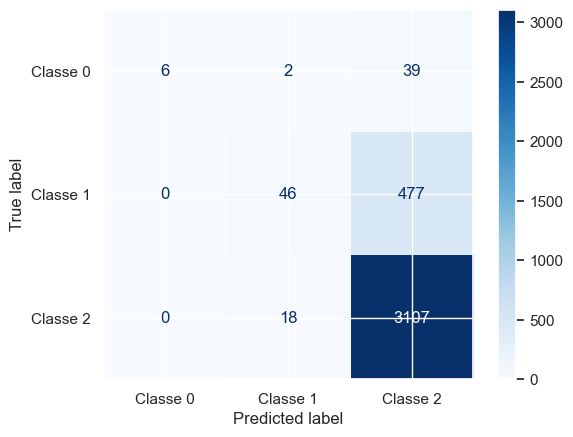

In [140]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calcul de la matrice de confusion
cm = confusion_matrix(y_test, y_pred_xgb)

# Affichage de la matrice de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Classe 0', 'Classe 1','Classe 2'])  # Modifier les labels selon vos classes
disp.plot(cmap='Blues')


Le graphique montre les courbes ROC pour les trois classes, avec des AUC de **0.97** pour la classe 0, **0.98** pour la classe 1 et **0.97**, indiquant une excellente performance du modèle. Les courbes sont proches du coin supérieur gauche, bien au-dessus de la ligne aléatoire (AUC = 0.5), démontrant une capacité élevée à distinguer les classes.

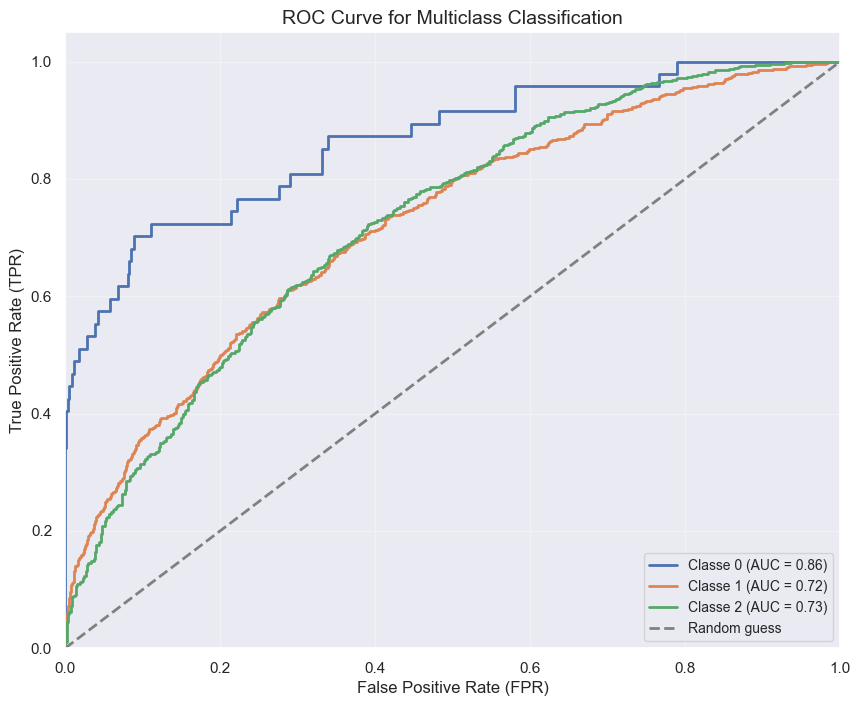

In [143]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt


# Binariser les labels
classes = np.unique(y_test) 
y_test_binarized = label_binarize(y_test, classes=classes)
y_proba_xgb = grid_search_xgboost.predict_proba(X_test)  # Probabilités de chaque classe

# Tracer les courbes ROC pour chaque classe
plt.figure(figsize=(10, 8))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_proba_xgb[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Classe {class_label} (AUC = {roc_auc:.2f})')

# Ajouter des éléments au graphique
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC Curve for Multiclass Classification', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.show()


## 5.2. LightGBM

### Entrainement du modèle

In [147]:
from lightgbm import LGBMClassifier

# Initialisation du classificateur LightGBM
lgbm = LGBMClassifier(random_state=42)

In [149]:
grid_search_lgbm = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    verbose=3,
    error_score='raise'
)

# Entraînement du modèle
grid_search_lgbm.fit(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001140 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 5747, number of used features: 24
[LightGBM] [Info] Start training from score -4.352368
[LightGBM] [Info] Start training from score -1.955702
[LightGBM] [Info] Start training from score -0.167640
[CV 1/3] END learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.8;, score=0.847 total time=   0.3s
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000632 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 418
[LightGBM] [Info] Number of data points in the train se

GridSearchCV(cv=3, error_score='raise',
             estimator=LGBMClassifier(random_state=42),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [10, 20],
                         'n_estimators': [100, 200, 500],
                         'subsample': [0.8, 1.0]},
             scoring='accuracy', verbose=3)

### Tester les performances du modèle

Le rapport de classification indique une précision globale de **89 %**. Les classes **0** et **2** sont bien prédites avec des F1-score de **0,84** et **0,94** , tandis que la classe **1** présentent un F1-score de **0,42** .

In [151]:
best_model_lgbm= grid_search_lgbm.best_estimator_

In [153]:
# Prédiction des étiquettes de test
y_pred_lgbm = best_model_lgbm.predict(X_test)

# Affichage du rapport de classification
print(classification_report(y_test, y_pred_lgbm))

              precision    recall  f1-score   support

           0       1.00      0.17      0.29        47
           1       0.61      0.09      0.16       523
           2       0.86      0.99      0.92      3125

    accuracy                           0.85      3695
   macro avg       0.82      0.42      0.46      3695
weighted avg       0.83      0.85      0.80      3695



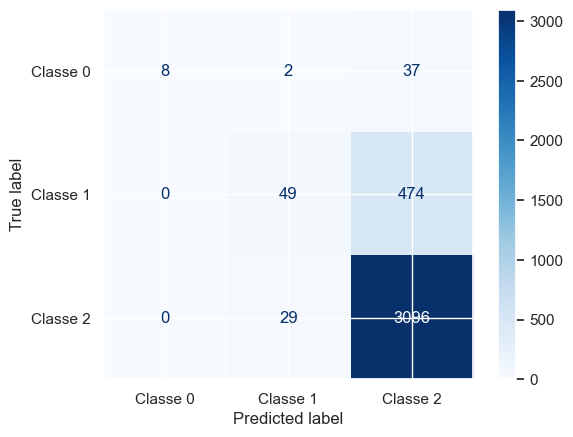

In [155]:
# Calcul de la matrice de confusion
cm = confusion_matrix(y_test, y_pred_lgbm)

# Affichage de la matrice de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Classe 0', 'Classe 1','Classe 2'])  # Modifier les labels selon vos classes
disp.plot(cmap='Blues')


Le graphique montre les courbes ROC pour les trois classes, avec des AUC de **0.97** pour la classe 0, **0.98** pour la classe 1 et **0.97** pour la classe 2, indiquant une excellente performance du modèle. Les courbes sont proches du coin supérieur gauche, bien au-dessus de la ligne aléatoire (AUC = 0.5), démontrant une capacité élevée à distinguer les classes.

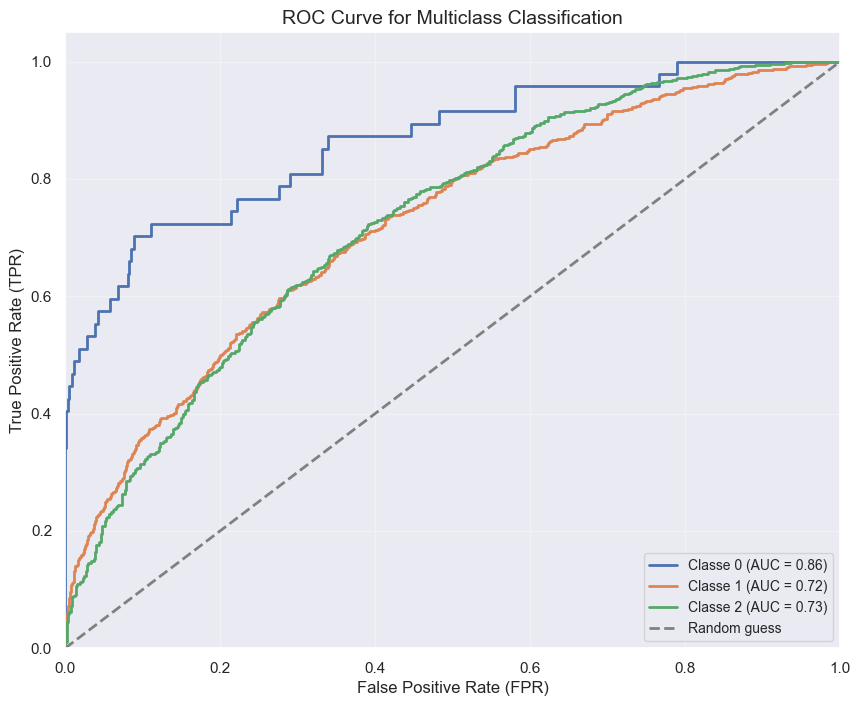

In [158]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt


# Binariser les labels
classes = np.unique(y_test) 
y_test_binarized = label_binarize(y_test, classes=classes)
y_proba_lgbm = grid_search_lgbm.predict_proba(X_test)  # Probabilités de chaque classe

# Tracer les courbes ROC pour chaque classe
plt.figure(figsize=(10, 8))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_proba_xgb[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Classe {class_label} (AUC = {roc_auc:.2f})')

# Ajouter des éléments au graphique
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC Curve for Multiclass Classification', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.show()


# MLFLOW 

In [161]:
pip install mlflow

In [163]:
import mlflow
import mlflow.sklearn

# RandomForest

## Suivi des expérimentations avec MLflow

Nous allons utiliser **MLflow** pour gérer et suivre l'entraînement d'un modèle de machine learning. Il crée une expérience, entraîne un **RandomForestClassifier**, et enregistre les **hyperparamètres**, **métriques de performance** (precision, recall, F1, accuracy), et le **modèle** dans un "run" MLflow. Cela permet de comparer facilement les différents essais et de suivre l'évolution des performances du modèle.


In [174]:
import mlflow
import mlflow.sklearn
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier

# Configuration de MLflow

# ici on définit une expérience pour le suivi des essais
# "Accident Multiclasses" est le nom de l'expérience. Elle permet de regrouper plusieurs runs sous une même thématique.
mlflow.set_experiment("Accident Multiclasses") 

# Entraînement du modèle
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Calcul des métriques de performance sur les données de test
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

# Enregistrement des résultats avec MLflow
with mlflow.start_run(): # Démarrage d'un "run" MLflow pour enregistrer les résultats
    # Enregistrement des hyperparamètres utilisés pour l'entraînement du modèle
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("random_state", 42)

    # Enregistrement des métriques de performance calculées pour ce modèle
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("accuracy", accuracy)

    # Enregistrement du modèle entraîné dans MLflow sous le nom "random_forest_model"
    mlflow.sklearn.log_model(rf, "random_forest_model")

    print("Modèle et métriques enregistrés dans MLflow")


2024/12/08 23:49:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modèle et métriques enregistrés dans MLflow


In [182]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import mlflow
import mlflow.sklearn

# Paramètres à tester
param_sets = [
    {"n_estimators": 50, "max_depth": 5},
    {"n_estimators": 100, "max_depth": 10},
    {"n_estimators": 150, "max_depth": None},
    {"n_estimators": 200, "max_depth": 20},
    {"n_estimators": 100, "max_depth": 15},
]

for params in param_sets:
    model_name = f"randomForest_Model_max_depth_{param_set['max_depth']}_lr_{param_set['n_estimators']}"
    with mlflow.start_run(run_name=model_name):  # Nom du run basé sur les paramètres        
        # Création du modèle avec les paramètres
        model_rf = RandomForestClassifier(
            n_estimators=params.get("n_estimators", 100),
            max_depth=params.get("max_depth", None),
            min_samples_split=params.get("min_samples_split", 2),
            random_state=42
        )
        model_rf.fit(X_train, y_train)
       
        # Prédictions
        y_pred_rf = model_rf.predict(X_test)
       
        # Calcul des métriques
        accuracy = accuracy_score(y_test, y_pred_rf)
        precision = precision_score(y_test, y_pred_rf, average='weighted')  # weighted for multiclass
        recall = recall_score(y_test, y_pred_rf, average='weighted')
        f1 = f1_score(y_test, y_pred_rf, average='weighted')
       
        # Enregistrement des métriques
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        
        # Enregistrement des paramètres
        mlflow.log_param("n_estimators", params.get("n_estimators", 100))
        mlflow.log_param("max_depth", params.get("max_depth", None))
        mlflow.log_param("min_samples_split", params.get("min_samples_split", 2))
       
        # Enregistrement du modèle
        mlflow.sklearn.log_model(model_rf, "random_forest_model")

2024/12/08 23:59:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/12/08 23:59:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/12/09 00:00:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/12/09 00:00:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/12/09 00:00:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


# Xgboost

Dans cette partie nous allons entraîner un modèle **XGBoost** pour la classification multiclasses et d’expérimenter avec plusieurs ensembles d’hyperparamètres. Les paramètres tels que `max_depth`, `eta` et `n_estimators` sont définis et testés dans différentes configurations pour optimiser les performances du modèle. 

Le processus d'entraînement inclut la prédiction sur un jeu de test et le calcul de diverses métriques de performance, comme la précision, le recall, le score F1 et l'accuracy. 

Tous les résultats, y compris les hyperparamètres et les métriques de performance, sont enregistrés dans **MLflow**, permettant un suivi complet des différentes expérimentations et une comparaison facile des performances de chaque modèle.

In [178]:
import mlflow
import mlflow.xgboost
import xgboost as xgb
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split

# Configuration de MLflow
mlflow.set_experiment("Accident Multiclasses")

# Paramètres à tester pour XGBoost
param_sets = [
    {'max_depth': 3, 'eta': 0.1, 'objective': 'multi:softmax', 'num_class': 3, 'eval_metric': 'merror'},
    {'max_depth': 6, 'eta': 0.3, 'objective': 'multi:softmax', 'num_class': 3, 'eval_metric': 'merror'},
    {'max_depth': 10, 'eta': 0.05, 'objective': 'multi:softmax', 'num_class': 3, 'eval_metric': 'merror'},
    {'max_depth': 5, 'eta': 0.2, 'objective': 'multi:softmax', 'num_class': 3, 'eval_metric': 'merror'},
    {'max_depth': 7, 'eta': 0.15, 'objective': 'multi:softmax', 'num_class': 3, 'eval_metric': 'merror'}
]

# Boucle pour tester différentes combinaisons d'hyperparamètres
for params in param_sets:
    # Entraînement du modèle XGBoost
    model_xgb = xgb.XGBClassifier(**params)
    model_xgb.fit(X_train, y_train)

    # Prédictions
    y_pred = model_xgb.predict(X_test)

    # Calcul des métriques
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)

    # Enregistrement des résultats avec MLflow
    with mlflow.start_run(run_name=f"Xgboost_max_depth_{params['max_depth']}_eta_{params['eta']}"):  # Nom du run avec les paramètres
        # Log des hyperparamètres du modèle
        for param, value in params.items():
            mlflow.log_param(param, value)  # Enregistrement des paramètres du modèle

        # Log des métriques de performance du modèle
        mlflow.log_metric("precision", precision)  # Enregistrement de la précision
        mlflow.log_metric("recall", recall)  # Enregistrement du recall
        mlflow.log_metric("f1_score", f1)  # Enregistrement du score F1
        mlflow.log_metric("accuracy", accuracy)  # Enregistrement de l'accuracy

        # Log du modèle XGBoost
        mlflow.xgboost.log_model(model_xgb, "xgboost_model")  # Enregistrement du modèle XGBoost

        print(f"Modèle avec max_depth={params['max_depth']} et eta={params['eta']} enregistré dans MLflow")  # Message de confirmation



2024/12/08 23:51:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modèle avec max_depth=3 et eta=0.1 enregistré dans MLflow


2024/12/08 23:51:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modèle avec max_depth=6 et eta=0.3 enregistré dans MLflow


2024/12/08 23:51:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modèle avec max_depth=10 et eta=0.05 enregistré dans MLflow


2024/12/08 23:51:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modèle avec max_depth=5 et eta=0.2 enregistré dans MLflow


2024/12/08 23:52:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modèle avec max_depth=7 et eta=0.15 enregistré dans MLflow


In [180]:
import mlflow
import mlflow.sklearn
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score

# Paramètres à tester
param_sets = [
    {'learning_rate': 0.1, 'num_leaves': 31, 'max_depth': 3, 'n_estimators': 100},
    {'learning_rate': 0.3, 'num_leaves': 35, 'max_depth': 6, 'n_estimators': 120},
    {'learning_rate': 0.05, 'num_leaves': 40, 'max_depth': 10, 'n_estimators': 150},
    {'learning_rate': 0.2, 'num_leaves': 45, 'max_depth': 5, 'n_estimators': 130},
    {'learning_rate': 0.15, 'num_leaves': 50, 'max_depth': 7, 'n_estimators': 110}
]

# Enregistrer les expériences dans MLflow
for param_set in param_sets:
    model_name = f"LightGBM_Model_max_depth_{param_set['max_depth']}_lr_{param_set['learning_rate']}"

    with mlflow.start_run(run_name=model_name):  # Nom du run basé sur les paramètres
        # Enregistrer les hyperparamètres dans MLflow
        for param, value in param_set.items():
            mlflow.log_param(param, value)
        
        # Initialiser et entraîner le modèle avec les paramètres
        lgbm = LGBMClassifier(random_state=42, **param_set)
        lgbm.fit(X_train, y_train)

        # Prédictions
        y_pred = lgbm.predict(X_test)

        # Calculer la précision
        accuracy = accuracy_score(y_test, y_pred)

        # Enregistrer le score de précision dans MLflow
        mlflow.log_metric('accuracy', accuracy)

        # Enregistrer le modèle dans MLflow
        mlflow.sklearn.log_model(lgbm, 'lightgbm_model')

        print(f"Run for {model_name} - Accuracy: {accuracy}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000824 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 422
[LightGBM] [Info] Number of data points in the train set: 8621, number of used features: 25
[LightGBM] [Info] Start training from score -4.352426
[LightGBM] [Info] Start training from score -1.955350
[LightGBM] [Info] Start training from score -0.167698
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

2024/12/08 23:54:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run for LightGBM_Model_max_depth_3_lr_0.1 - Accuracy: 0.8492557510148849
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001666 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 422
[LightGBM] [Info] Number of data points in the train set: 8621, number of used features: 25
[LightGBM] [Info] Start training from score -4.352426
[LightGBM] [Info] Start training from score -1.955350
[LightGBM] [Info] Start training from score -0.167698
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

2024/12/08 23:55:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run for LightGBM_Model_max_depth_6_lr_0.3 - Accuracy: 0.8476319350473613
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 422
[LightGBM] [Info] Number of data points in the train set: 8621, number of used features: 25
[LightGBM] [Info] Start training from score -4.352426
[LightGBM] [Info] Start training from score -1.955350
[LightGBM] [Info] Start training from score -0.167698
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


2024/12/08 23:55:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run for LightGBM_Model_max_depth_10_lr_0.05 - Accuracy: 0.8554803788903924
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000810 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 422
[LightGBM] [Info] Number of data points in the train set: 8621, number of used features: 25
[LightGBM] [Info] Start training from score -4.352426
[LightGBM] [Info] Start training from score -1.955350
[LightGBM] [Info] Start training from score -0.167698
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

2024/12/08 23:55:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run for LightGBM_Model_max_depth_5_lr_0.2 - Accuracy: 0.854127198917456
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 422
[LightGBM] [Info] Number of data points in the train set: 8621, number of used features: 25
[LightGBM] [Info] Start training from score -4.352426
[LightGBM] [Info] Start training from score -1.955350
[LightGBM] [Info] Start training from score -0.167698
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

2024/12/08 23:55:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run for LightGBM_Model_max_depth_7_lr_0.15 - Accuracy: 0.8543978349120434


Dans cette partie nous allons calculer et visualiser la matrice de confusion, puis enregistrer l'image générée dans MLflow pour un suivi et une gestion des résultats expérimentaux.

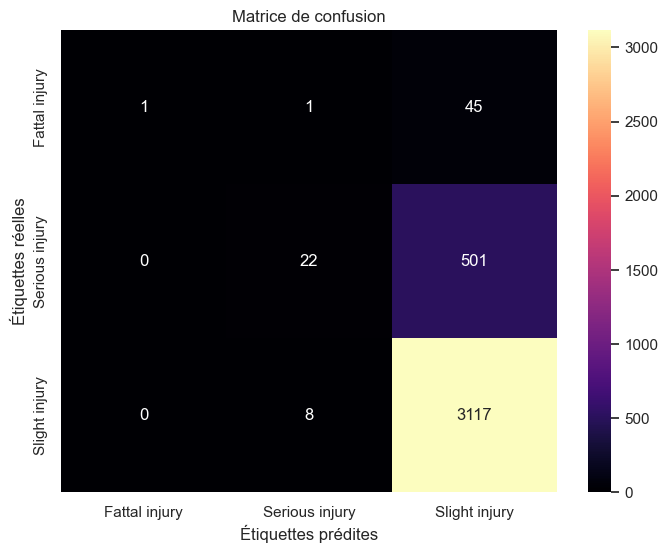

In [187]:
import mlflow
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd

# Calcul de la matrice de confusion
cm = confusion_matrix(y_test, y_pred_rf)

# Définir les étiquettes des classes
class_labels = ["Fattal injury", "Serious injury", "Slight injury"]

# Visualisation de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels, cmap="magma")
plt.xlabel("Étiquettes prédites")
plt.ylabel("Étiquettes réelles")
plt.title("Matrice de confusion")

# Sauvegarde de la figure
plt.savefig("confusion_matrix.png")

# Enregistrement avec MLflow
with mlflow.start_run():
    mlflow.log_artifact("confusion_matrix.png")


On va enregistrer un modèle de machine learning dans MLflow, en enregistrant le modèle comme artefact, puis en l'ajoutant au registre de modèles sous un nom spécifique pour une gestion centralisée.

In [189]:
import mlflow
import mlflow.sklearn
if mlflow.active_run():
    mlflow.end_run()

with mlflow.start_run() as run:
    run_id = run.info.run_id  
    model_uri = f"runs:/{run_id}/model"  
    
    mlflow.sklearn.log_model(
        sk_model=model_rf,
        artifact_path="model",
        input_example=X_train,
    )
  
    registered_model = mlflow.register_model(model_uri=model_uri, name="mlflow_accident")


Successfully registered model 'mlflow_accident'.
Created version '1' of model 'mlflow_accident'.


Ce script envoie des données sous forme de requête HTTP POST à un serveur local pour obtenir une prédiction de la sévérité d'un accident. Les données, sous forme de dictionnaire JSON, sont envoyées au modèle de machine learning, et le script récupère et affiche la prédiction (Slight Injury, Serious Injury, Fatal Injury). Dans notre cas le résultat est **slight injury**

In [196]:
import requests
import json

url = "http://127.0.0.1:1234/invocations"
headers = {"Content-Type": "application/json"}

data = {
    "dataframe_records": [
        {
            'Time': 61320,
            'Day_of_week': 1,
            'Age_band_of_driver': 2,
            'Sex_of_driver': 1,
            'Educational_level': 3,
            'Vehicle_driver_relation': 3,
            'Driving_experience': 1,
            'Type_of_vehicle': 1,
            'Owner_of_vehicle': 1,
            'Service_year_of_vehicle': 3,
            'Defect_of_vehicle': 1,
            'Area_accident_occured': 1,
            'Lanes_or_Medians': 2,
            'Road_allignment': 1,
            'Types_of_Junction': 1,
            'Road_surface_type': 1,
            'Road_surface_conditions': 1,
            'Light_conditions': 2,
            'Weather_conditions': 1,
            'Type_of_collision': 2,
            'Number_of_vehicles_involved': 3,
            'Number_of_casualties': 1,
            'Vehicle_movement': 4,
            'Age_band_of_casualty': 1,
            'Pedestrian_movement': 1,
            'Cause_of_accident': 1,
            'Work_of_casuality': 1,
            'Fitness_of_casuality': 1
        }
    ]
}

# Envoi de la requête POST
response = requests.post(url, headers=headers, data=json.dumps(data))

# Vérification du code de réponse
if response.status_code == 200:
    # Récupération de la prédiction (sévérité)
    result = response.json()
    prediction = result.get('predictions', [None])[0]  # Récupérer la première prédiction

    # Mapping de la prédiction en fonction de la classe
    if prediction == 1:
        print('Slight Injury')
    elif prediction == 2:
        print('Serious Injury')
    elif prediction == 3:
        print('Fatal Injury')
    else:
        print('Unknown Severity')

else:
    print(f"{response.status_code}: {response.text}")


Serious Injury
